# Natural Language Processing With TensorFlow

Processing natural language and predicting sentiment.

#### Topics:

- Loading datasets from the Tensorflow Datasets API
- Tokenizing text data into a numerical representation 
- Creating sequences (with padding) out of tokenized data
- Creating a sequence-aware LSTM model with text embedding
- Using customer and premade callbacks 
- Evaluating a models performance 


###### IMDB Dataset 

`imdb_reviews` dataset from TF datasets API. data contains 50,000 movie reviews that are categorized as either positive (1) or negative (0). Will only use the first 20 words from each review to speed up training. 


In [1]:
# Import Libraries 

import tensorflow as tf
import tensorflow_datasets as tfds 
import numpy as np, matplotlib.pyplot as plt

# version 2.0 or higher
print("TensorFlow Version: ", tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow Version:  2.12.0


In [2]:
# dataset 
text_data = tfds.load('imdb_reviews', split = ['train', 'test'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete3OMYND/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete3OMYND/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete3OMYND/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
# empty lists for holding 
train_text = []
train_labels = []
test_text = []
test_labels = []

# Iterate over the imdb data set and add text + labels to their respective list
for row in text_data[0]:
    # takes just the first 20 words from the review 
    train_text.append(row['text'].numpy().decode('utf-8').split()[:20])
    train_labels.append(row['label'].numpy())
    
for row in text_data[1]:
    test_text.append(row['text'].numpy().decode('utf-8').split()[:20])
    test_labels.append(row['label'].numpy())

# Print a sample of the training set
print("First 5 samples of the TRAINING SET \n", 30*'=')
for i in range(5):
    review = "POSITIVE" if train_labels[i] == 1 else "NEGATIVE"
    print("REVIEW SENTIMENT: ", review)
    print("REVIEW TEXT: ", ' '.join(train_text[i]))
    print(30*'-')

First 5 samples of the TRAINING SET 
REVIEW SENTIMENT:  NEGATIVE
REVIEW TEXT:  This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors,
------------------------------
REVIEW SENTIMENT:  NEGATIVE
REVIEW TEXT:  I have been known to fall asleep during films, but this is usually due to a combination of things including,
------------------------------
REVIEW SENTIMENT:  NEGATIVE
REVIEW TEXT:  Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as
------------------------------
REVIEW SENTIMENT:  POSITIVE
REVIEW TEXT:  This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead
------------------------------
REVIEW SENTIMENT:  POSITIVE
REVIEW TEXT:  As others have mentioned, all the women that go nude in this film are mostly absolutely gorgeous. The plot very
------------------------------


#### Transform Text into Numerical Representation 

Computers only receive numbers so the words have to be converted into numerical representation. TensorFlow `Tokenizer` can be used for this. It maps new word it encounters (limited by the `num_words` attribute) to a number. The numeric representation then needs to be padded with the `pad_sequences` function so that all inputs to the future model will be of equal length. 

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create and fits a TensorFlow Tokenizer 
tokenizer = Tokenizer(num_words = 10_000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_text)

# Creates sequences of numeric representations of words 
training_sequences = tokenizer.texts_to_sequences(train_text)
# pads sequences so all have the same length
training_sequences = pad_sequences(training_sequences, maxlen = 20)

# Process test data in the same way for later evaluation 
testing_sequences = tokenizer.texts_to_sequences(test_text)
testing_sequences = pad_sequences(testing_sequences, maxlen = 20)

# Prints a sample of the new sequences
print("Processed Text Data \n", 30*'-')
for i in range(5):
    print(training_sequences[i], '\n')

Processed Text Data 
 ------------------------------
[   5   13   24  202  329   66   83   27 6022   10   31 1117 4618   65
  370    1  259   33   59  909] 

[   4   20   57  507    9 1118 2953  295  387   22    5    8  364  650
    9    3 1297    6  252    1] 

[2350 7150    2    1 5215 6023   10    3  799    1    7 2023 1202    7
 1556 7151  218  625  516   17] 

[   5    8    2  285    6   15   16    3 3711 1203 1677   36    2 1144
    6    2  230   64  178 2482] 

[  17  571   20 4126   40    2  517   14  178 4127   10    5   15   33
  983  202 6024    2  117   42] 



#### Custom Callback

Callbacks are used in Tensorflow to allow user intervention during model training. A callback can be executed ata number of specific instances during model training. 

`CustomCallback` will stop the model from training once the model reaches 95% accuracy on the training set. 

In [6]:
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95:
            print("Accuracy over 95% .............. Stopping Training")
            self.model.stop_training = True

my_callback = CustomCallback()

#### Predefined Callback: `LearningRAteScheduler`

To dynamically update the learning rate of the optimizer, works by taking a function that updates the learning rate as an argument.


In [7]:
from tensorflow.keras.callbacks import LearningRateScheduler

# creates a function that updates the learning rate based on the epoch number 
def scheduler(epoch, lr):
    if epoch < 2:
        return 0.01
    else:
        return lr * .99
    
lr_scheduler = LearningRateScheduler(scheduler)

### NN for sentiment analysis 

Creating a NN that will take the processed movie reviews as inputs and output its sentiment (0-1). Basic NLP models have a structure similar to the following:

**Embedding Layer --> Bidirectional LSTM Layer --> Dense Layer --> Output**

Roles of each layers:

- **Embedding:** Transform the previous scaler representation of our words into an n-dimensional vector. This will put words more associated with negative/postive reviews closer with similar words in the n-dimensional space. 
- **Bidirectional LSTM:** (Long Short-term Memory): This layer is the sequence aware in both the forward and backward direction. This means that this layer can be interpret meaning carried across a phrase which is very important in understanding language. 
- **Dense** Applies multiplication and addition operators and a non-linear activation function to find non-linear patterns in the data.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# input dimensions is equal to number of words tokenized (defined above)
input_dim = 10_000
# input length will be the length of out padded sequences 
input_length = 20

# defines a text classifier model 
model = Sequential([
    Embedding(input_dim = input_dim, output_dim = 64, input_length=input_length),
    Bidirectional(LSTM(150)),
    Dropout(0.4),
    Dense(512, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid')
])

model.compile(
    loss = 'binary_crossentropy',
    optimizer=Adam(),
    metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 64)            640000    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              258000    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 512)               154112    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                        

In [9]:
# training the model 

history = model.fit(
    np.array(training_sequences), #must convert it to a numpy array before sending it to model
    np.array(train_labels), # must convert it to a numpy array before sending it to model 
    epochs = 100,
    batch_size = 128,
    callbacks = [my_callback, lr_scheduler],
    verbose = 0
)

Accuracy over 95% .............. Stopping Training


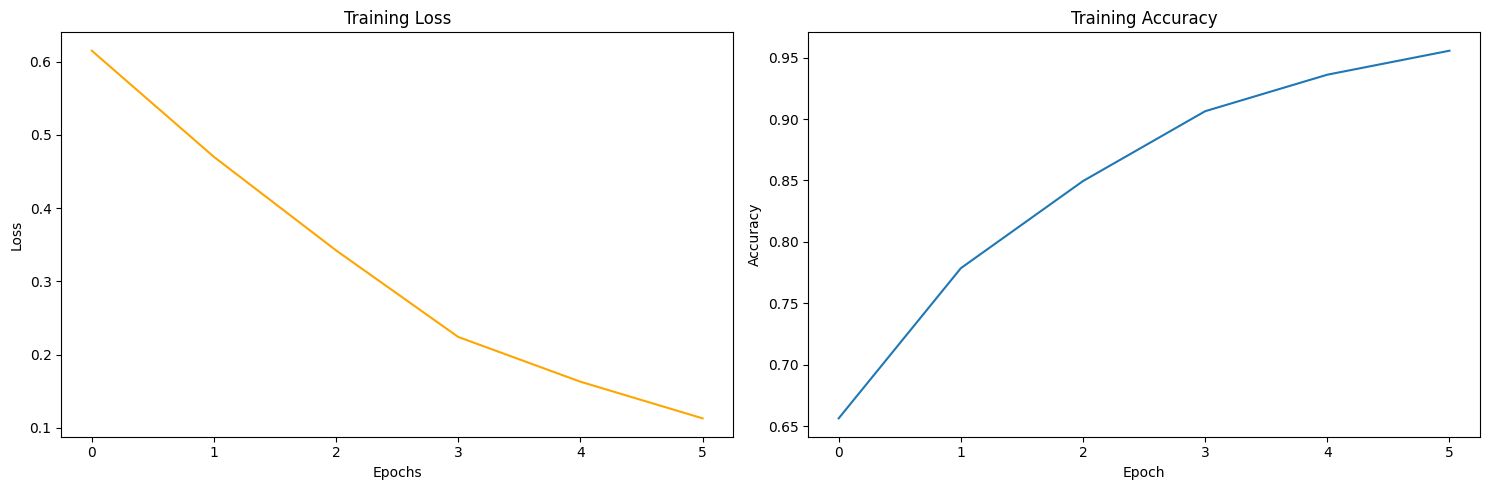

In [11]:
fig, axs = plt.subplots(1,2, figsize = (15,5))

axs[0].plot(history.history['loss'], color = 'orange')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")

axs[1].plot(history.history['accuracy'])
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training Accuracy")

plt.tight_layout()
plt.show()

### Evaluate Model Performance 

In [13]:
# Measuring the model performance on the testing data 
evaluation = model.evaluate(
    np.array(testing_sequences),
    np.array(test_labels),
    batch_size = 128,
    verbose = 0
)

print(f"Model Accuracy on Test Data: {round(evaluation[1],3)}%")

Model Accuracy on Test Data: 0.653%


In [14]:
# New review 

NEW_REVIEW = \
"""
This movie was ridiculous. I wish I didn't waste my time watching this movie.
"""

In [15]:
# Process the new review the same way the test text was processed 
new_review_sequence = tokenizer.texts_to_sequences([NEW_REVIEW])
new_review_sequence = pad_sequences(new_review_sequence, maxlen = 20)

#sends new review to be predicted by the model 
new_review_prediction = round(model.predict(np.array(new_review_sequence))[0][0])
sentiment = "NEGATIVE" if new_review_prediction == 0 else "POSITIVE"

# displays what the model predicted
print("MOVIE REVIEW: ", NEW_REVIEW)
print(f"MODEL PREDICTED SENTIMENT: ", sentiment)

1/1 [==============================] - 1s 707ms/step
MOVIE REVIEW:  
This movie was ridiculous. I wish I didn't waste my time watching this movie.

MODEL PREDICTED SENTIMENT:  NEGATIVE
